In [195]:
import numpy as np
import matplotlib.pyplot as plt
import time
from mlrose_hiive.opt_probs import TSPOpt, DiscreteOpt
from mlrose_hiive.fitness import TravellingSales, FlipFlop, ContinuousPeaks,Knapsack
import random
plt.style.use('seaborn-darkgrid')

In [ ]:
from mlrose_hiive.algorithms import random_hill_climb, simulated_annealing, genetic_alg, mimic
from mlrose_hiive.algorithms.decay import ExpDecay

IMAGE_DIR = '../figures/Optimization/'

In [39]:



start_time = 0.
times = []


def plot_helper(x_axis, y_axis, label):
    """Plot helper.
        Args:
          x_axis (ndarray): x axis to plot over.
          y_axis (ndarray): y axis to plot.
          label (ndarray): label.
        Returns:
          None.
        """

    y_mean, y_std = np.mean(y_axis, axis=0), np.std(y_axis, axis=0)
    plot = plt.plot(x_axis, y_mean, label=label)
    plt.fill_between(x_axis, y_mean - y_std, y_mean + y_std, alpha=0.1, color=plot[0].get_color())


def set_plot_title_labels(title, x_label, y_label):
    """Set plot title and labels.
        Args:
          title (string): plot title.
          x_label (string): x label.
          y_label (string): y label.
        Returns:
          None.
        """
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel(x_label)
    plt.ylabel(y_label)





In [102]:
start_time = 0.
times = []

def time_callback(iteration, attempt=None, done=None, state=None, fitness=None, fitness_evaluations=None,curve=None, user_data=None):
    """Time callback for saving time elapsed at each iteration of the algorithm.
        Args:
          iteration (int): current iteration.
          attempt (int): current attempt.
          done (bool): id we are done iterating.
          state (list): current best state.
          fitness (float): current best fitness.
          curve (ndarray): current fitness curve.
          user_data (any): current iteration.
        Returns:
          continue (bool): True, to continue iterating.
        """
    # Define global variables
    global start_time, times

    # At first iteration, save start time and reset list of times, else save time elapsed since start
    if iteration == 0:
        start_time = time.time()
        times = []
    else:
        times.append(time.time() - start_time)

    # Return always True to continue iterating
    return True

In [19]:



def plot_ga_mimic_optimization(problem, param_name, random_seeds, **kwargs):
    """Plot objective function vs parameter for GA and MIMIC.
        Args:
         problem (DiscreteOpt): mlrose Discrete Optimization problem to run.
         param_name (string): GA and MIMIC param to plot objective vs, 'pop_size' or 'keep_pct'.
         random_seeds (list): random seeds to use for averaging results over multiple random runs.
         kwargs (dict): additional arguments to pass for curves plotting:
                    - pop_sizes (list or ndarray): lits or array of population sizes to objective plot vs.
                    - keep_pcts (list or ndarray): lits or array of keep percentages to objective plot vs.
                    - ga_pop_size (int): GA population size.
                    - ga_keep_pct (float): GA keep percentage.
                    - ga_max_iters (int): GA maximum number of iterations.
                    - mimic_pop_size (int): MIMIC population size.
                    - mimic_keep_pct (float): MIMIC keep percentage.
                    - mimic_max_iters (int): MIMIC maximum number of iterations.
                    - plot_name (string): name of the plot.
                    - plot_ylabel (string): y axis label.
        Returns:
         None.
        """

    ga_curve, mimic_curve = [], []  # curves to plot for GA and MIMIC

    # Initialize, for GA and MIMIC, the parameter we don't have to loop through and label for plotting
    if param_name == 'keep_pct':
        ga_pop_size = kwargs['ga_pop_size']
        mimic_pop_size = kwargs['mimic_pop_size']
        label = 'Percentage to keep'
    elif param_name == 'pop_size':
        ga_keep_pct = kwargs['ga_keep_pct']
        mimic_keep_pct = kwargs['mimic_keep_pct']
        label = 'Population size'
    else:
        raise Exception('Param name has to be either pop_size or keep_pct')  # raise exception if invalid entry

    # For all parameters
    for param in kwargs[param_name + 's']:

        print('\nGA & MIMIC: {} = {:.3f}'.format(param_name, param))
        ga_objectives, mimic_objectives = [], []  # list of results from multiple random runs for current parameter

        # Initialize, for GA and MIMIC, the parameter we have to loop through
        if param_name == 'keep_pct':
            ga_keep_pct = param
            mimic_keep_pct = param
        elif param_name == 'pop_size':
            ga_pop_size = int(param)
            mimic_pop_size = int(param)

        # For multiple random runs
        for random_seed in random_seeds:

            # Run GA and get best state and objective found
            best_state, best_objective, _ = genetic_alg(problem,
                                                        pop_size=ga_pop_size,  # population size
                                                        pop_breed_percent=1.0 - ga_keep_pct,  # percentage to breed
                                                        max_attempts=kwargs['ga_max_iters'],  # unlimited attempts
                                                        max_iters=kwargs['ga_max_iters'],
                                                        curve=False, random_state=random_seed)
            ga_objectives.append(best_objective)
            print('GA: best_objective = {:.3f}'.format(best_objective))

            # Run MIMIC and get best state and objective found
            best_state, best_objective, _ = mimic(problem,
                                                  pop_size=mimic_pop_size,  # population size
                                                  keep_pct=mimic_keep_pct,  # percentage to keep
                                                  max_attempts=kwargs['mimic_max_iters'],  # unlimited attempts
                                                  max_iters=kwargs['mimic_max_iters'],
                                                  curve=False, random_state=random_seed)
            mimic_objectives.append(best_objective)
            print('MIMIC: best_objective = {:.3f}'.format(best_objective))

        # Append random run to GA and MIMIC curves
        ga_curve.append(ga_objectives)
        mimic_curve.append(mimic_objectives)

    # Plot, set title and labels
    plt.figure()
    plot_helper(x_axis=kwargs[param_name + 's'], y_axis=np.array(ga_curve).T, label='GA')
    plot_helper(x_axis=kwargs[param_name + 's'], y_axis=np.array(mimic_curve).T, label='MIMIC')
    set_plot_title_labels(title='{} - Objective vs. {}'.format(kwargs['plot_name'], label),
                                x_label=label,
                                y_label=kwargs['plot_ylabel'])

    # Save figure
    plt.savefig(IMAGE_DIR + '{}_objective_vs_{}'.format(kwargs['plot_name'], param_name))


def plot_sa_optimization(problem, random_seeds, **kwargs):
    """Plot objective function vs temperature for SA.
        Args:
         problem (DiscreteOpt): mlrose Discrete Optimization problem to run.
         random_seeds (list): random seeds to use for averaging results over multiple random runs.
         kwargs (dict): additional arguments to pass for curves plotting:
                    - sa_decay_rates (list or ndarray): lits or array of exponential decay rates to objective plot vs.
                    - sa_init_temp (float): SA initial temperature.
                    - sa_min_temp (float): SA minimum temperature.
                    - sa_max_iters (int): SA maximum number of iterations.
                    - plot_name (string): name of the plot.
                    - plot_ylabel (string): y axis label.
        Returns:
         None.
        """

    sa_curve = []  # curve to plot for SA

    # For all temperature exponential decay rate
    for exp_decay_rate in kwargs['sa_decay_rates']:

        # Define exponential decay schedule
        print('\nSA: exp decay rate = {:.3f}'.format(exp_decay_rate))
        exp_decay = ExpDecay(init_temp=kwargs['sa_init_temp'],
                             exp_const=exp_decay_rate,
                             min_temp=kwargs['sa_min_temp'])

        sa_objectives = []  # list of results from multiple random runs for current rate

        # For multiple random runs
        for random_seed in random_seeds:

            # Run SA and get best state and objective found
            best_state, best_objective, _ = simulated_annealing(problem,
                                                                schedule=exp_decay,
                                                                max_attempts=kwargs['sa_max_iters'],
                                                                max_iters=kwargs['sa_max_iters'],
                                                                curve=False, random_state=random_seed)
            sa_objectives.append(best_objective)
            print('SA: best_fitness = {:.3f}'.format(best_objective))

        sa_curve.append(sa_objectives)  # append random run to SA curve

    # Plot, set title and labels
    plt.figure()
    plot_helper(x_axis=kwargs['sa_decay_rates'], y_axis=np.array(sa_curve).T, label='SA')
    set_plot_title_labels(title='{} - Objective vs. temperature exponential decay rate'.format(kwargs['plot_name']),
                                x_label='Exponential decay rate',
                                y_label=kwargs['plot_ylabel'])

    # Save figure
    plt.savefig(IMAGE_DIR + '{}_objective_vs_temp'.format(kwargs['plot_name']))


def plot_optimizations(problem, random_seeds, **kwargs):
    """Plot optimizations for SA temperature and GA and MIMIC population sizes and fractions to keep.
       Args:
        problem (DiscreteOpt): mlrose Discrete Optimization problem to run.
        random_seeds (list): random seeds to use for averaging results over multiple random runs.
        kwargs (dict): additional arguments to pass for curves plotting:
                   - sa_decay_rates (list or ndarray): lits or array of exponential decay rates to objective plot vs.
                   - sa_init_temp (float): SA initial temperature.
                   - sa_min_temp (float): SA minimum temperature.
                   - sa_max_iters (int): SA maximum number of iterations.
                   - pop_sizes (list or ndarray): lits or array of population sizes to objective plot vs.
                   - keep_pcts (list or ndarray): lits or array of keep percentages to objective plot vs.
                   - ga_pop_size (int): GA population size.
                   - ga_keep_pct (float): GA keep percentage.
                   - ga_max_iters (int): GA maximum number of iterations.
                   - mimic_pop_size (int): MIMIC population size.
                   - mimic_keep_pct (float): MIMIC keep percentage.
                   - mimic_max_iters (int): MIMIC maximum number of iterations.
                   - plot_name (string): name of the plot.
                   - plot_ylabel (string): y axis label.
       Returns:
        None.
       """
    plot_sa_optimization(problem, random_seeds, **kwargs)
    plot_ga_mimic_optimization(problem, 'pop_size', random_seeds, **kwargs)
    plot_ga_mimic_optimization(problem, 'keep_pct', random_seeds, **kwargs)


def plot_performances(problem, random_seeds, **kwargs):
    """Plot performances for RHC, SA, GA and MIMIC.
       Args:
        problem (DiscreteOpt): mlrose Discrete Optimization problem to run.
        random_seeds (list): random seeds to use for averaging results over multiple random runs.
        kwargs (dict): additional arguments to pass for curves plotting:
                   - sa_init_temp (float): SA initial temperature.
                   - sa_min_temp (float): SA minimum temperature.
                   - sa_exp_decay_rate (float): SA temperature exponential decay rate.
                   - sa_max_iters (int): SA maximum number of iterations.
                   - pop_sizes (list or ndarray): lits or array of population sizes to objective plot vs.
                   - keep_pcts (list or ndarray): lits or array of keep percentages to objective plot vs.
                   - ga_pop_size (int): GA population size.
                   - ga_keep_pct (float): GA keep percentage.
                   - ga_max_iters (int): GA maximum number of iterations.
                   - mimic_pop_size (int): MIMIC population size.
                   - mimic_keep_pct (float): MIMIC keep percentage.
                   - mimic_max_iters (int): MIMIC maximum number of iterations.
                   - plot_name (string): name of the plot.
                   - plot_ylabel (string): y axis label.
       Returns:
        None.
       """

    # Initialize lists of objectives curves and time curves
    rhc_objectives, sa_objectives, ga_objectives, mimic_objectives = [], [], [], []
    rhc_times, sa_times, ga_times, mimic_times = [], [], [], []

    # Set an exponential decay schedule for SA
    exp_decay = ExpDecay(init_temp=kwargs['sa_init_temp'],
                         exp_const=kwargs['sa_exp_decay_rate'],
                         min_temp=kwargs['sa_min_temp'])

    # For multiple random runs
    for random_seed in random_seeds:

        # Run RHC and get best state and objective found
        _, best_objective, objective_curve = random_hill_climb(problem,
                                                               max_attempts=kwargs['rhc_max_iters'],
                                                               max_iters=kwargs['rhc_max_iters'],
                                                               curve=True, random_state=random_seed,
                                                               state_fitness_callback=time_callback,
                                                               callback_user_info=[])

        rhc_objectives.append(objective_curve)
        rhc_times.append(utils.times)
        print('\nRHC: best_objective = {:.3f}'.format(best_objective))

        # Run SA and get best state and objective found
        _, best_objective, objective_curve = simulated_annealing(problem,
                                                                 schedule=exp_decay,
                                                                 max_attempts=kwargs['sa_max_iters'],
                                                                 max_iters=kwargs['sa_max_iters'],
                                                                 curve=True, random_state=random_seed,
                                                                 state_fitness_callback=time_callback,
                                                                 callback_user_info=[])

        sa_objectives.append(objective_curve)
        sa_times.append(utils.times)
        print('SA: best_objective = {:.3f}'.format(best_objective))

        # Run GA and get best state and objective found
        _, best_objective, objective_curve = genetic_alg(problem,
                                                         pop_size=kwargs['ga_pop_size'],
                                                         pop_breed_percent=1.0 - kwargs['ga_keep_pct'],
                                                         max_attempts=kwargs['ga_max_iters'],
                                                         max_iters=kwargs['ga_max_iters'],
                                                         curve=True, random_state=random_seed,
                                                         state_fitness_callback=time_callback,
                                                         callback_user_info=[])

        ga_objectives.append(objective_curve)
        ga_times.append(utils.times)
        print('GA: best_objective = {:.3f}'.format(best_objective))

        # Run MIMIC and get best state and objective found
        _, best_objective, objective_curve = mimic(problem,
                                                   pop_size=kwargs['mimic_pop_size'],
                                                   keep_pct=kwargs['mimic_keep_pct'],
                                                   max_attempts=kwargs['mimic_max_iters'],
                                                   max_iters=kwargs['mimic_max_iters'],
                                                   curve=True, random_state=random_seed,
                                                   state_fitness_callback=time_callback,
                                                   callback_user_info=[])

        mimic_objectives.append(objective_curve)
        mimic_times.append(utils.times)
        print('MIMIC: best_objective = {:.3f}'.format(best_objective))

    # Array of iterations to plot objectives vs. for RHC, SA, GA and MIMIC
    rhc_iterations = np.arange(1, kwargs['rhc_max_iters']+1)
    sa_iterations = np.arange(1, kwargs['sa_max_iters']+1)
    ga_iterations = np.arange(1, kwargs['ga_max_iters']+1)
    mimic_iterations = np.arange(1, kwargs['mimic_max_iters']+1)

    # Plot objective curves, set title and labels
    plt.figure()
    plot_helper(x_axis=rhc_iterations, y_axis=np.array(rhc_objectives), label='RHC')
    plot_helper(x_axis=sa_iterations, y_axis=np.array(sa_objectives), label='SA')
    plot_helper(x_axis=ga_iterations, y_axis=np.array(ga_objectives), label='GA')
    plot_helper(x_axis=mimic_iterations, y_axis=np.array(mimic_objectives), label='MIMIC')
    set_plot_title_labels(title='{} - Objective versus iterations'.format(kwargs['plot_name']),
                                x_label='Iterations',
                                y_label=kwargs['plot_ylabel'])

    # Save figure
    plt.savefig(IMAGE_DIR + '{}_objective_vs_iterations'.format(kwargs['plot_name']))

    # Plot times, set title and labels
    plt.figure()
    plot_helper(x_axis=rhc_iterations, y_axis=np.array(rhc_times), label='RHC')
    plot_helper(x_axis=sa_iterations, y_axis=np.array(sa_times), label='SA')
    plot_helper(x_axis=ga_iterations, y_axis=np.array(ga_times), label='GA')
    plot_helper(x_axis=mimic_iterations, y_axis=np.array(mimic_times), label='MIMIC')
    set_plot_title_labels(title='{} - Time versus iterations'.format(kwargs['plot_name']),
                                x_label='Iterations',
                                y_label='Time (seconds)')

    # Save figure
    plt.savefig(IMAGE_DIR + '{}_time_vs_iterations'.format(kwargs['plot_name']))

## Travelling Saleman

In [23]:
#Define list of inter-distances between each pair of the following cities (in order from 0 to 9):

# cities_distances = [(0, 1, 0.274), (0, 2, 1.367), (1, 2, 1.091), (0, 3, 1.422), (1, 3, 1.153), (2, 3, 1.038),
#                     (0, 4, 1.870), (1, 4, 1.602), (2, 4, 1.495), (3, 4, 0.475), (0, 5, 1.652), (1, 5, 1.381),
#                     (2, 5, 1.537), (3, 5, 0.515), (4, 5, 0.539), (0, 6, 1.504), (1, 6, 1.324), (2, 6, 1.862),
#                     (3, 6, 1.060), (4, 6, 1.097), (5, 6, 0.664), (0, 7, 1.301), (1, 7, 1.031), (2, 7, 1.712),
#                     (3, 7, 1.031), (4, 7, 1.261), (5, 7, 0.893), (6, 7, 0.350), (0, 8, 1.219), (1, 8, 0.948),
#                     (2, 8, 1.923), (3, 8, 1.484), (4, 8, 1.723), (5, 8, 1.396), (6, 8, 0.872), (7, 8, 0.526),
#                     (0, 9, 0.529), (1, 9, 0.258), (2, 9, 1.233), (3, 9, 1.137), (4, 9, 1.560), (5, 9, 1.343),
#                     (6, 9, 1.131), (7, 9, 0.816), (8, 9, 0.704)]

# Rome, Florence, Barcelona, Paris, London, Amsterdam, Berlin, Prague, Budapest, Venice
cities_distances = [(0, 1, -0.274), (0, 2, -1.367), (1, 2, -1.091), (0, 3, -1.422), (1, 3, -1.153), (2, 3, -1.038),
                    (0, 4, -1.870), (1, 4, -1.602), (2, 4, -1.495), (3, 4, -0.475), (0, 5, -1.652), (1, 5, -1.381),
                    (2, 5, -1.537), (3, 5, -0.515), (4, 5, -0.539), (0, 6, -1.504), (1, 6, -1.324), (2, 6, -1.862),
                    (3, 6, -1.060), (4, 6, -1.097), (5, 6, -0.664), (0, 7, -1.301), (1, 7, -1.031), (2, 7, -1.712),
                    (3, 7, -1.031), (4, 7, -1.261), (5, 7, -0.893), (6, 7, -0.350), (0, 8, -1.219), (1, 8, -0.948),
                    (2, 8, -1.923), (3, 8, -1.484), (4, 8, -1.723), (5, 8, -1.396), (6, 8, -0.872), (7, 8, -0.526),
                    (0, 9, -0.529), (1, 9, -0.258), (2, 9, -1.233), (3, 9, -1.137), (4, 9, -1.560), (5, 9, -1.343),
                    (6, 9, -1.131), (7, 9, -0.816), (8, 9, -0.704)]

length = 10

In [31]:
# Define Travel Salesman objective function and problem
tsp_objective = TravellingSales(distances=cities_distances)
problem = TSPOpt(length=length, fitness_fn=tsp_objective, maximize=True)
problem.set_mimic_fast_mode(True)  # set fast MIMIC

Exception: The distance between each pair of nodes must be greater than 0.

In [32]:
best_state, best_fitness,_ = genetic_alg(problem, random_state = 2)
print(best_state)
print(best_fitness)

[7 6 5 4 3 2 1 0 9 8]
6.1899999999999995


6.1899999999999995


## Contiuous Peaks

In [96]:
# Define Four Peaks objective function and problem
continous_fitness = ContinuousPeaks(t_pct=0.2)
problem = DiscreteOpt(length=200, fitness_fn=continous_fitness, maximize=True, max_val=2)
problem.set_mimic_fast_mode(True)  # set fast MIMIC

0

In [98]:
best_state, best_fitness,objective_curve = genetic_alg(problem,max_iters=10000, random_state = 7,curve=True,
                                                       state_fitness_callback=time_callback,
                                                        callback_user_info=[])
# print(best_state)
print(best_fitness)
print(len(objective_curve))

TypeError: time_callback() got an unexpected keyword argument 'fitness_evaluations'

In [89]:
 best_state, best_objective, objective_curve = random_hill_climb(problem,
                                                                 max_iters=10000,
                                                                 restarts=10,
                                                                 random_state = 7,
                                                               curve=True)
    
# print(best_state)
print(best_objective)
print(len(objective_curve))

12.0
10


In [105]:
exp_decay = ExpDecay(init_temp=100,
                             exp_const=0.1,
                             min_temp=0.001)
best_state, best_objective, objective_curve = simulated_annealing(problem,
                                                                 schedule=exp_decay,
                                                                  max_iters=10000,
                                                                 curve=True,
                                                                 random_state=7,
                                                                 )

# print(best_state)
print(best_objective)
print(len(objective_curve))

In [104]:
# Run MIMIC and get best state and objective found
best_state, best_objective, objective_curve = mimic(problem,
                                           max_iters=10000,
                                         curve=True,
                                         random_state=7,
                                        state_fitness_callback=time_callback,
                                        callback_user_info=[])
# print(best_state)
print(best_objective)
print(len(objective_curve))
print(times)

38.0
24
[0.1705338954925537, 0.3362710475921631, 0.48612093925476074, 0.6331131458282471, 0.7918288707733154, 0.9307918548583984, 1.0889039039611816, 1.2596311569213867, 1.3999989032745361, 1.5433568954467773, 1.716019868850708, 1.8580169677734375, 2.0099599361419678, 2.1705739498138428, 2.376033067703247, 2.5225698947906494, 2.735818862915039, 3.083343744277954, 3.4384031295776367, 3.834156036376953, 4.229002952575684, 4.611956834793091, 4.998003959655762, 5.3454530239105225]


### Fitness vs N

In [244]:
random_state = 32
lengths = np.arange(20,301,20)
best_fitnesses = np.zeros((4,len(lengths)))
for i,n in enumerate(lengths):
    # Define Four Peaks objective function and problem
    continous_fitness = ContinuousPeaks(t_pct=0.2)
    problem = DiscreteOpt(length=int(n), fitness_fn=continous_fitness, maximize=True, max_val=2)
    problem.set_mimic_fast_mode(True)  # set fast MIMIC
    
    
    #RHC
    _, best_objective, objective_curve = random_hill_climb(problem,max_iters=10000,restarts=20,random_state = random_state,curve=False)
    best_fitnesses[0,i] = best_objective
    
    #SA
    exp_decay = ExpDecay(init_temp=100,exp_const=0.1,min_temp=0.001)
    _, best_objective, objective_curve = simulated_annealing(problem,schedule=exp_decay,max_iters=10000
                                                             ,curve=False,random_state=random_state)
    best_fitnesses[1,i] = best_objective
    #GA
    _, best_objective,objective_curve = genetic_alg(problem,max_iters=10000, random_state = random_state,curve=False)
    best_fitnesses[2,i] = best_objective
    #Mimic
    _, best_objective, objective_curve = mimic(problem,max_iters=10000,curve=False,random_state=random_state)    
    best_fitnesses[3,i] = best_objective
        
    

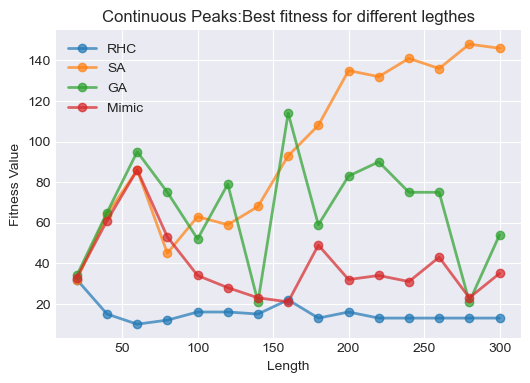

In [245]:
plt.figure(figsize=(6,4))
plt.plot(lengths,best_fitnesses[0],label='RHC', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[1],label='SA', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[2],label='GA', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[3],label='Mimic', marker='o',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xscale('log')
plt.title("Continuous Peaks:Best fitness for different legthes")
plt.legend(loc='best')
plt.xlabel("Length")
plt.ylabel("Fitness Value")
plt.savefig(IMAGE_DIR+"CP_fitness_N.pdf")

In [228]:
### fitness curve 
curves = []
time_curves = []
random_state = 32
max_attempts = 10
continous_fitness = ContinuousPeaks(t_pct=0.2)
problem = DiscreteOpt(length=150, fitness_fn=continous_fitness, maximize=True, max_val=2)
problem.set_mimic_fast_mode(True)  # set fast MIMIC


#RHC
start = time.time()
_, best_objective, objective_curve = random_hill_climb(problem,max_iters=10000,restarts=100,max_attempts=max_attempts,random_state = random_state,curve=True,
                                                      state_fitness_callback=time_callback,
                                                        callback_user_info=[])
print("RHC fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))
curves.append(objective_curve) 
time_curves.append(times)

#SA
start = time.time()
exp_decay = ExpDecay(init_temp=200,exp_const=0.2,min_temp=0.001)
_, best_objective, objective_curve = simulated_annealing(problem,schedule=exp_decay,max_iters=10000
                                                         ,curve=True,random_state=random_state,max_attempts= max_attempts,
                                                        state_fitness_callback=time_callback,
                                                        callback_user_info=[])
print("SA fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))

curves.append(objective_curve) 
time_curves.append(times)

#GA
start = time.time()
_, best_objective,objective_curve = genetic_alg(problem,max_iters=10000, max_attempts= max_attempts,random_state = random_state,curve=True,
                                               state_fitness_callback=time_callback,
                                                        callback_user_info=[])
curves.append(objective_curve) 
time_curves.append(times)
print("GA fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))


#Mimic
start = time.time()
_, best_objective, objective_curve = mimic(problem,max_iters=10000,max_attempts=max_attempts,curve=True,random_state=random_state,
                                          state_fitness_callback=time_callback,
                                                        callback_user_info=[])    
curves.append(objective_curve) 
time_curves.append(times)
print("Mimic fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))



RHC fitness:  14.0
Time:  0.6946420669555664
num of iterations:  27
SA fitness:  84.0
Time:  14.84593415260315
num of iterations:  6218
GA fitness:  57.0
Time:  2.0111796855926514
num of iterations:  59
Mimic fitness:  45.0
Time:  3.745795726776123
num of iterations:  30


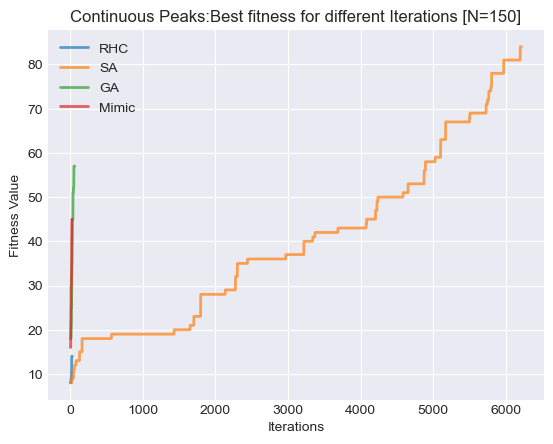

In [231]:
iterations = np.arange(1,10001+1)
plt.plot(np.arange(1,len(curves[0][:,0])+1),curves[0][:,0],label='RHC',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[1][:,0])+1),curves[1][:,0],label='SA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[2][:,0])+1),curves[2][:,0],label='GA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[3][:,0])+1),curves[3][:,0],label='Mimic',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xlim([1, 10001])
# ax.set_xscale('log')
plt.title("Continuous Peaks:Best fitness for different Iterations [N=150]")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("Fitness Value")
plt.savefig(IMAGE_DIR+"CP_fitness_iterations.pdf")

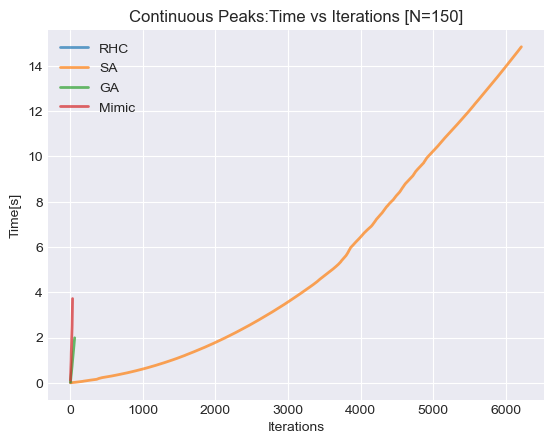

In [232]:
iterations = np.arange(1,10001+1)
plt.plot(np.arange(1,len(time_curves[0])+1),time_curves[0],label='RHC',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[1])+1),time_curves[1],label='SA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[2])+1),time_curves[2],label='GA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[3])+1),time_curves[3],label='Mimic',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xlim([1, 10001])
# ax.set_xscale('log')
plt.title("Continuous Peaks:Time vs Iterations [N=150]")
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("Time[s]")
plt.savefig(IMAGE_DIR+"CP_time_iterations.pdf")

In [214]:
random.randint(1,10)

9

### Knapsack

In [217]:
num_points = 10
max_weight_pct = 0.4
weights = list(np.random.randint(low = 1, high = 100, size = num_points))
values = list(np.random.randint(low = 1, high = 100, size = num_points))
problem = DiscreteOpt(length = num_points,fitness_fn = Knapsack(weights,values,max_weight_pct))
problem.set_mimic_fast_mode(True)  # set fast MIMIC

In [220]:
random_state = 32
num_points_array = np.arange(20,301,20)
best_fitnesses = np.zeros((4,len(lengths)))
for i,num_points in enumerate(num_points_array):
    max_weight_pct = 0.4
    weights = list(np.random.randint(low = 1, high = 100, size = num_points))
    values = list(np.random.randint(low = 1, high = 100, size = num_points))
    problem = DiscreteOpt(length = int(num_points),fitness_fn = Knapsack(weights,values,max_weight_pct))
    problem.set_mimic_fast_mode(True)  # set fast MIMIC
    
    
    #RHC
    _, best_objective, objective_curve = random_hill_climb(problem,max_iters=10000,restarts=20,random_state = random_state,curve=False)
    best_fitnesses[0,i] = best_objective
    
    #SA
    exp_decay = ExpDecay(init_temp=100,exp_const=0.1,min_temp=0.001)
    _, best_objective, objective_curve = simulated_annealing(problem,schedule=exp_decay,max_iters=10000
                                                             ,curve=False,random_state=random_state)
    best_fitnesses[1,i] = best_objective
    #GA
    _, best_objective,objective_curve = genetic_alg(problem,max_iters=10000, random_state = random_state,curve=False)
    best_fitnesses[2,i] = best_objective
    #Mimic
    _, best_objective, objective_curve = mimic(problem,max_iters=10000,curve=False,random_state=random_state)    
    best_fitnesses[3,i] = best_objective
        
    

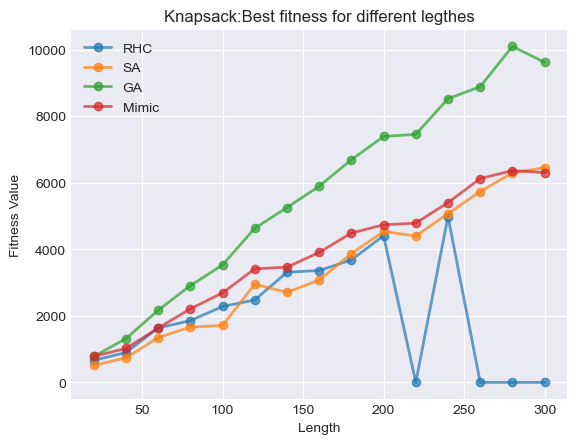

In [243]:
plt.plot(lengths,best_fitnesses[0],label='RHC', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[1],label='SA', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[2],label='GA', marker='o',  linewidth=2, alpha=0.7)
plt.plot(lengths,best_fitnesses[3],label='Mimic', marker='o',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xscale('log')
plt.title("Knapsack:Best fitness for different legthes")
plt.legend(loc='best')
plt.xlabel("Length")
plt.ylabel("Fitness Value")
plt.savefig(IMAGE_DIR+"KP_fitness_N.pdf")

In [238]:
### fitness curve 
curves = []
time_curves = []
random_state = 32
max_attempts = 10
num_points = 100
max_weight_pct = 0.4
weights = list(np.random.randint(low = 1, high = 100, size = num_points))
values = list(np.random.randint(low = 1, high = 100, size = num_points))
problem = DiscreteOpt(length = int(num_points),fitness_fn = Knapsack(weights,values,max_weight_pct))
problem.set_mimic_fast_mode(True)  # set fast MIMIC


#RHC
start = time.time()
_, best_objective, objective_curve = random_hill_climb(problem,max_iters=10000,restarts=100,max_attempts=max_attempts,random_state = random_state,curve=True,
                                                      state_fitness_callback=time_callback,
                                                        callback_user_info=[])
print("RHC fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))
curves.append(objective_curve) 
time_curves.append(times)

#SA
start = time.time()
exp_decay = ExpDecay(init_temp=100,exp_const=0.1,min_temp=0.001)
_, best_objective, objective_curve = simulated_annealing(problem,schedule=exp_decay,max_iters=10000
                                                         ,curve=True,random_state=random_state,max_attempts= max_attempts,
                                                        state_fitness_callback=time_callback,
                                                        callback_user_info=[])
print("SA fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))

curves.append(objective_curve) 
time_curves.append(times)

#GA
start = time.time()
_, best_objective,objective_curve = genetic_alg(problem,max_iters=10000, max_attempts= max_attempts,random_state = random_state,curve=True,
                                               state_fitness_callback=time_callback,
                                                        callback_user_info=[])
curves.append(objective_curve) 
time_curves.append(times)
print("GA fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))


#Mimic
start = time.time()
_, best_objective, objective_curve = mimic(problem,max_iters=10000,max_attempts=max_attempts,curve=True,random_state=random_state,
                                          state_fitness_callback=time_callback,
                                                        callback_user_info=[])    
curves.append(objective_curve) 
time_curves.append(times)
print("Mimic fitness: ",best_objective)
print("Time: ", time.time()-start)
print("num of iterations: ", len(objective_curve))



RHC fitness:  2595.0
Time:  0.5015852451324463
num of iterations:  19
SA fitness:  2231.0
Time:  0.008275032043457031
num of iterations:  60
GA fitness:  3879.0
Time:  2.081775665283203
num of iterations:  92
Mimic fitness:  2764.0
Time:  1.285189151763916
num of iterations:  13


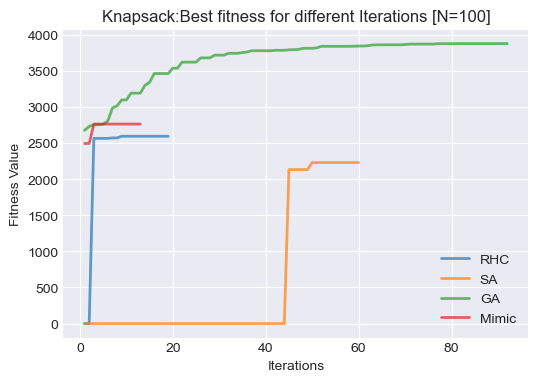

In [239]:
plt.figure(figsize=(6,4))
iterations = np.arange(1,10001+1)
plt.plot(np.arange(1,len(curves[0][:,0])+1),curves[0][:,0],label='RHC',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[1][:,0])+1),curves[1][:,0],label='SA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[2][:,0])+1),curves[2][:,0],label='GA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(curves[3][:,0])+1),curves[3][:,0],label='Mimic',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xlim([1, 10001])
# ax.set_xscale('log')
plt.title("Knapsack:Best fitness for different Iterations [N={}]".format(num_points))
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("Fitness Value")
plt.savefig(IMAGE_DIR+"KS_fitness_iterations.pdf")

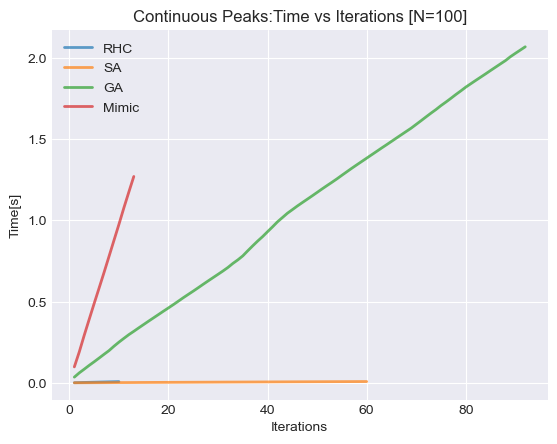

In [242]:
iterations = np.arange(1,10001+1)
plt.plot(np.arange(1,len(time_curves[0])+1),time_curves[0],label='RHC',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[1])+1),time_curves[1],label='SA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[2])+1),time_curves[2],label='GA',  linewidth=2, alpha=0.7)
plt.plot(np.arange(1,len(time_curves[3])+1),time_curves[3],label='Mimic',  linewidth=2, alpha=0.7)
ax = plt.gca()
# ax.set_ylim([0, 100])
# ax.set_xlim([1, 10001])
# ax.set_xscale('log')
plt.title("Continuous Peaks:Time vs Iterations [N={}]".format(num_points))
plt.legend(loc='best')
plt.xlabel("Iterations")
plt.ylabel("Time[s]")
plt.savefig(IMAGE_DIR+"KS_time_iterations.pdf")